In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

c = 299792458.0
G = 6.67430e-11
M_sun = 1.989e30

In [37]:
# Use M0 = Msun
L0   = G * M_sun / c**2          # [m]
rho0 = c**2 / (G * L0**2)        # [kg/m^3]
p0   = rho0                      # p := P/c^2 has same units as rho (kg/m^3)

In [38]:
Gamma = 1.3569

rho_r_ref = 1e13 * 1000.0              # 1e13 g/cm^3 -> 1e16 kg/m^3

# Convert (P/c^2) from dyn/cm^2 to SI and then to kg/m^3:
P_over_c2_ref = (1.5689e31 * 0.1) / (c**2)   # dyn/cm^2 -> Pa, then /c^2 -> kg/m^3

K_SI  = P_over_c2_ref / (rho_r_ref**Gamma)

# Dimensionless Khat for: p_hat = Khat * rho_r_hat^Gamma
# where p_hat = (P/c^2)/p0 and rho_r_hat = rho_r/rho0
Khat = K_SI * (rho0**Gamma) / p0            # = K_SI * rho0^(Gamma-1)

In [39]:
def eos_from_p(p_hat: float):
    """
    Input:  p_hat = (P/c^2)/p0
    Output: rho_hat = rho/rho0, rho_r_hat = rho_r/rho0
    """
    p_hat = max(float(p_hat), 0.0)
    if p_hat == 0.0:
        return 0.0, 0.0

    rho_r_hat = (p_hat / Khat)**(1.0 / Gamma)
    rho_hat   = rho_r_hat + (Khat / (Gamma - 1.0)) * (rho_r_hat**Gamma)
    return rho_hat, rho_r_hat

In [40]:
def rhs_b(r, y):
    m, nu, p, mP = y
    rho, rho_r = eos_from_p(p)

    if r <= 0.0:
        return [0.0, 0.0, 0.0, 0.0]

    denom = r * (r - 2.0*m)

    dm  = 4.0*np.pi * r**2 * rho
    dnu = 2.0 * (m + 4.0*np.pi*r**3*p) / denom
    dp  = - (m + 4.0*np.pi*r**3*p) * (rho + p) / denom

    dmp = 4.0*np.pi * (1.0 - 2.0*m/r)**(-0.5) * r**2 * rho_r

    return [dm, dnu, dp, dmp]

def surface_event(r, y):
    return y[2]  # p

surface_event.terminal = True
surface_event.direction = -1

In [41]:
def integrate_star_b(pc_hat, r0=1e-6, rmax=50.0):
    rho_c, rho_r_c = eos_from_p(pc_hat)

    m0  = (4.0*np.pi/3.0) * rho_c   * r0**3
    mP0 = (4.0*np.pi/3.0) * rho_r_c * r0**3
    nu0 = 0.0
    y0  = [m0, nu0, pc_hat, mP0]

    sol = solve_ivp(
        rhs_b, (r0, rmax), y0,
        events=surface_event,
        rtol=1e-8, atol=1e-10,
        max_step=0.05
    )

    if sol.status == 1 and sol.t_events[0].size > 0:
        R_hat = sol.t_events[0][0]
        m_hat, nu_hat, p_hat, mP_hat = sol.y_events[0][0]
        return R_hat, m_hat, mP_hat
    else:
        # If no surface found, return NaNs so we can filter it out
        return np.nan, np.nan, np.nan

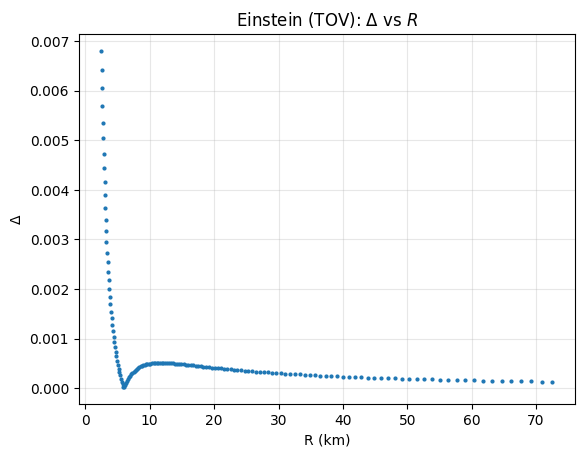

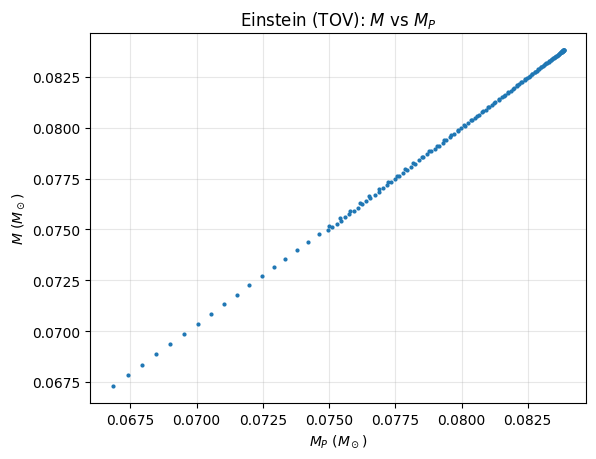

In [42]:
pc_list = np.logspace(-12, -2, 240)

R_km, M, MP, Delta = [], [], [], []

for pc in pc_list:
    R_hat, M_hat, MP_hat = integrate_star_b(pc)

    if np.isfinite(R_hat):
        R_km.append(R_hat * L0 / 1000.0)
        M.append(M_hat)
        MP.append(MP_hat)
        Delta.append(abs(MP_hat - M_hat) / M_hat)   # Eq (17)

R_km  = np.array(R_km)
M     = np.array(M)
MP    = np.array(MP)
Delta = np.array(Delta)

plt.figure()
plt.plot(R_km, Delta, ".", markersize=4)
plt.xlabel("R (km)")
plt.ylabel(r"$\Delta$")
plt.title(r"Einstein (TOV): $\Delta$ vs $R$")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(MP, M, ".", markersize=4)
plt.xlabel(r"$M_P$ ($M_\odot$)")
plt.ylabel(r"$M$ ($M_\odot$)")
plt.title(r"Einstein (TOV): $M$ vs $M_P$")
plt.grid(True, alpha=0.3)
plt.show()